In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

In [2]:
df=pd.read_csv('water_pollution_disease.csv')
print('Dataframe info: \n')
display(df.info())
df.columns

Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Country                                        3000 non-null   object 
 1   Region                                         3000 non-null   object 
 2   Year                                           3000 non-null   int64  
 3   Water Source Type                              3000 non-null   object 
 4   Contaminant Level (ppm)                        3000 non-null   float64
 5   pH Level                                       3000 non-null   float64
 6   Turbidity (NTU)                                3000 non-null   float64
 7   Dissolved Oxygen (mg/L)                        3000 non-null   float64
 8   Nitrate Level (mg/L)                           3000 non-null   float64
 9   Lead Concentration (µg/L)         

None

Index(['Country', 'Region', 'Year', 'Water Source Type',
       'Contaminant Level (ppm)', 'pH Level', 'Turbidity (NTU)',
       'Dissolved Oxygen (mg/L)', 'Nitrate Level (mg/L)',
       'Lead Concentration (µg/L)', 'Bacteria Count (CFU/mL)',
       'Water Treatment Method', 'Access to Clean Water (% of Population)',
       'Diarrheal Cases per 100,000 people',
       'Cholera Cases per 100,000 people', 'Typhoid Cases per 100,000 people',
       'Infant Mortality Rate (per 1,000 live births)', 'GDP per Capita (USD)',
       'Healthcare Access Index (0-100)', 'Urbanization Rate (%)',
       'Sanitation Coverage (% of Population)', 'Rainfall (mm per year)',
       'Temperature (°C)', 'Population Density (people per km²)'],
      dtype='object')

In [3]:
# tweaking/modifying  the dataset 

df["Cholera Cases per 100,000 people"] = (
    0.02 * df["Bacteria Count (CFU/mL)"] +
    0.098 * df["Contaminant Level (ppm)"] +
    np.random.normal(0, 10, size=len(df))  # noise
).clip(lower=0)  # no negatives

# Example: Typhoid cases from Turbidity + Sanitation (inverse)
df["Typhoid Cases per 100,000 people"] = (
    0.7 * df["Turbidity (NTU)"] +
    0.5 * (100 - df["Sanitation Coverage (% of Population)"]) +
    np.random.normal(0, 10, size=len(df))
).clip(lower=0)

# Example: Diarrheal cases from Nitrate + Lead
df["Diarrheal Cases per 100,000 people"] = (
    0.9 * df["Nitrate Level (mg/L)"] +
    0.7 * df["Lead Concentration (µg/L)"] +
    np.random.normal(0, 10, size=len(df))
).clip(lower=0) 



In [4]:
df = df.drop(['Water Treatment Method','Region','Country','Year'], axis=1)
df.rename(columns={
    'Water Source Type': 'water_source',
    'Contaminant Level (ppm)': 'contaminant_level',
    'pH Level': 'ph_level',
    'Turbidity (NTU)': 'turbidity',
    'Dissolved Oxygen (mg/L)': 'dissolved_oxygen',
    'Nitrate Level (mg/L)': 'nitrate_level',
    'Lead Concentration (µg/L)': 'lead_concentration',
    'Bacteria Count (CFU/mL)': 'bacteria_count',
    'Access to Clean Water (% of Population)': 'access_to_clean_water',
    'Diarrheal Cases per 100,000 people': 'diarrheal_cases',
    'Cholera Cases per 100,000 people': 'cholera_cases',
    'Typhoid Cases per 100,000 people': 'typhoid_cases',
    'Infant Mortality Rate (per 1,000 live births)': 'infant_mortality_rate',
    'GDP per Capita (USD)': 'gdp',
    'Healthcare Access Index (0-100)': 'healthcare_access',
    'Urbanization Rate (%)': 'urbanization_rate',
    'Sanitation Coverage (% of Population)': 'sanitation_coverage',
    'Rainfall (mm per year)': 'rainfall_per_year',
    'Temperature (°C)': 'temperature',
    'Population Density (people per km²)': 'population_density'
}, inplace=True)



In [6]:
# tweaking/modifying dataset
np.random.seed(42)  # reproducibility

df["abdominal_pain"] = np.random.randint(0, 11, size=len(df))
df["nausea_vomiting"] = np.random.randint(0, 11, size=len(df))
df["weakness_loss_of_appetite"] = np.random.randint(0, 11, size=len(df))
df["fever"] = np.random.randint(0, 11, size=len(df))


df["Diarrheal Cases per 100,000 people"] = (
    7.0 * df["abdominal_pain"] +
    6.0 * df["nausea_vomiting"] +
    2.0 * df["weakness_loss_of_appetite"] +
    1.0 * df["fever"] +
    np.random.normal(0, 3, size=len(df))
).clip(lower=0)

df["Cholera Cases per 100,000 people"] = (
    1.5 * df["weakness_loss_of_appetite"] +
    2.0 * df["fever"] +
    0.5 * df["nausea_vomiting"] +
    np.random.normal(0, 2, size=len(df))
).clip(lower=0)

df["Typhoid Cases per 100,000 people"] = (
    6.0 * df["fever"] +
    5.0 * df["abdominal_pain"] +
    4.5 * df["nausea_vomiting"] +
    3.0 * df["weakness_loss_of_appetite"] +
    2.0 * (df["abdominal_pain"] * df["fever"]) +
    1.5 * (df["nausea_vomiting"] * df["fever"]) +
    1.2 * (df["weakness_loss_of_appetite"] * df["nausea_vomiting"]) +
    0.8 * (df["abdominal_pain"] * df["nausea_vomiting"]) +
    np.random.normal(0, 3, size=len(df))
).clip(lower=0)



In [7]:
df.shape

(3000, 27)

In [8]:
df.columns

Index(['water_source', 'contaminant_level', 'ph_level', 'turbidity',
       'dissolved_oxygen', 'nitrate_level', 'lead_concentration',
       'bacteria_count', 'access_to_clean_water', 'diarrheal_cases',
       'cholera_cases', 'typhoid_cases', 'infant_mortality_rate', 'gdp',
       'healthcare_access', 'urbanization_rate', 'sanitation_coverage',
       'rainfall_per_year', 'temperature', 'population_density',
       'abdominal_pain', 'nausea_vomiting', 'weakness_loss_of_appetite',
       'fever', 'Diarrheal Cases per 100,000 people',
       'Cholera Cases per 100,000 people', 'Typhoid Cases per 100,000 people'],
      dtype='object')

In [9]:
df = pd.get_dummies(df, drop_first=True)

bool_cols = ['water_source_Pond', 'water_source_River', 'water_source_Spring', 'water_source_Tap', 'water_source_Well']
df[bool_cols] = df[bool_cols].astype(int)
df.shape

(3000, 31)

In [10]:
print('Dataframe num summary statistics: \n')
display(df.describe())

df.head()

Dataframe num summary statistics: 



,contaminant_level,ph_level,turbidity,dissolved_oxygen,nitrate_level,lead_concentration,bacteria_count,access_to_clean_water,diarrheal_cases,cholera_cases,...,weakness_loss_of_appetite,fever,"Diarrheal Cases per 100,000 people","Cholera Cases per 100,000 people","Typhoid Cases per 100,000 people",water_source_Pond,water_source_River,water_source_Spring,water_source_Tap,water_source_Well
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,4.954390,7.255847,2.480023,6.492850,25.08025,10.047913,2488.477333,64.612333,29.790255,50.447750,...,5.000667,5.027333,79.520938,20.047585,229.934253,0.150000,0.179333,0.177333,0.167000,0.166000
std,2.860072,0.720464,1.419984,2.027966,14.50517,5.798238,1431.421553,20.308463,16.459546,30.054778,...,3.155416,3.206766,30.202152,8.523525,126.301397,0.357131,0.383695,0.382014,0.373038,0.372143
min,0.000000,6.000000,0.000000,3.000000,0.05000,0.000000,0.000000,30.010000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,11.083877,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.560000,6.630000,1.257500,4.710000,12.52500,5.120000,1268.000000,47.027500,17.071098,25.805596,...,2.000000,2.000000,57.853011,13.461896,131.865432,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.950000,7.280000,2.460000,6.490000,24.79000,10.065000,2469.000000,64.780000,29.493784,49.000560,...,5.000000,5.000000,79.779733,20.025104,212.423448,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.400000,7.870000,3.660000,8.252500,37.91000,15.032500,3736.250000,82.302500,41.874545,75.756717,...,8.000000,8.000000,100.784675,26.354926,304.171845,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,8.500000,4.990000,10.000000,49.99000,20.000000,4998.000000,99.990000,79.450558,122.237774,...,10.000000,10.000000,154.935384,42.160737,685.922239,1.000000,1.000000,1.000000,1.000000,1.000000


,contaminant_level,ph_level,turbidity,dissolved_oxygen,nitrate_level,lead_concentration,bacteria_count,access_to_clean_water,diarrheal_cases,cholera_cases,...,weakness_loss_of_appetite,fever,"Diarrheal Cases per 100,000 people","Cholera Cases per 100,000 people","Typhoid Cases per 100,000 people",water_source_Pond,water_source_River,water_source_Spring,water_source_Tap,water_source_Well
0,6.06,7.12,3.93,4.28,8.28,7.89,3344,33.60,25.344445,56.948517,...,4,5,76.162522,21.458934,212.980818,0,0,0,0,0
1,5.24,7.84,4.79,3.86,15.74,14.68,2122,89.54,35.575470,32.390517,...,8,0,58.682727,12.220810,103.106967,0,0,0,0,1
2,0.24,6.43,0.79,3.42,36.67,9.96,2330,35.29,33.651142,79.352948,...,6,8,112.089698,27.806927,370.576492,1,0,0,0,0
3,7.91,6.71,1.96,3.12,36.92,6.77,3779,57.53,27.408495,100.180004,...,6,4,84.842955,20.726573,205.237019,0,0,0,0,1
4,0.12,8.16,4.22,9.15,49.35,12.51,4182,36.60,47.996593,87.162798,...,5,6,46.291830,18.911465,117.568753,0,0,0,0,1


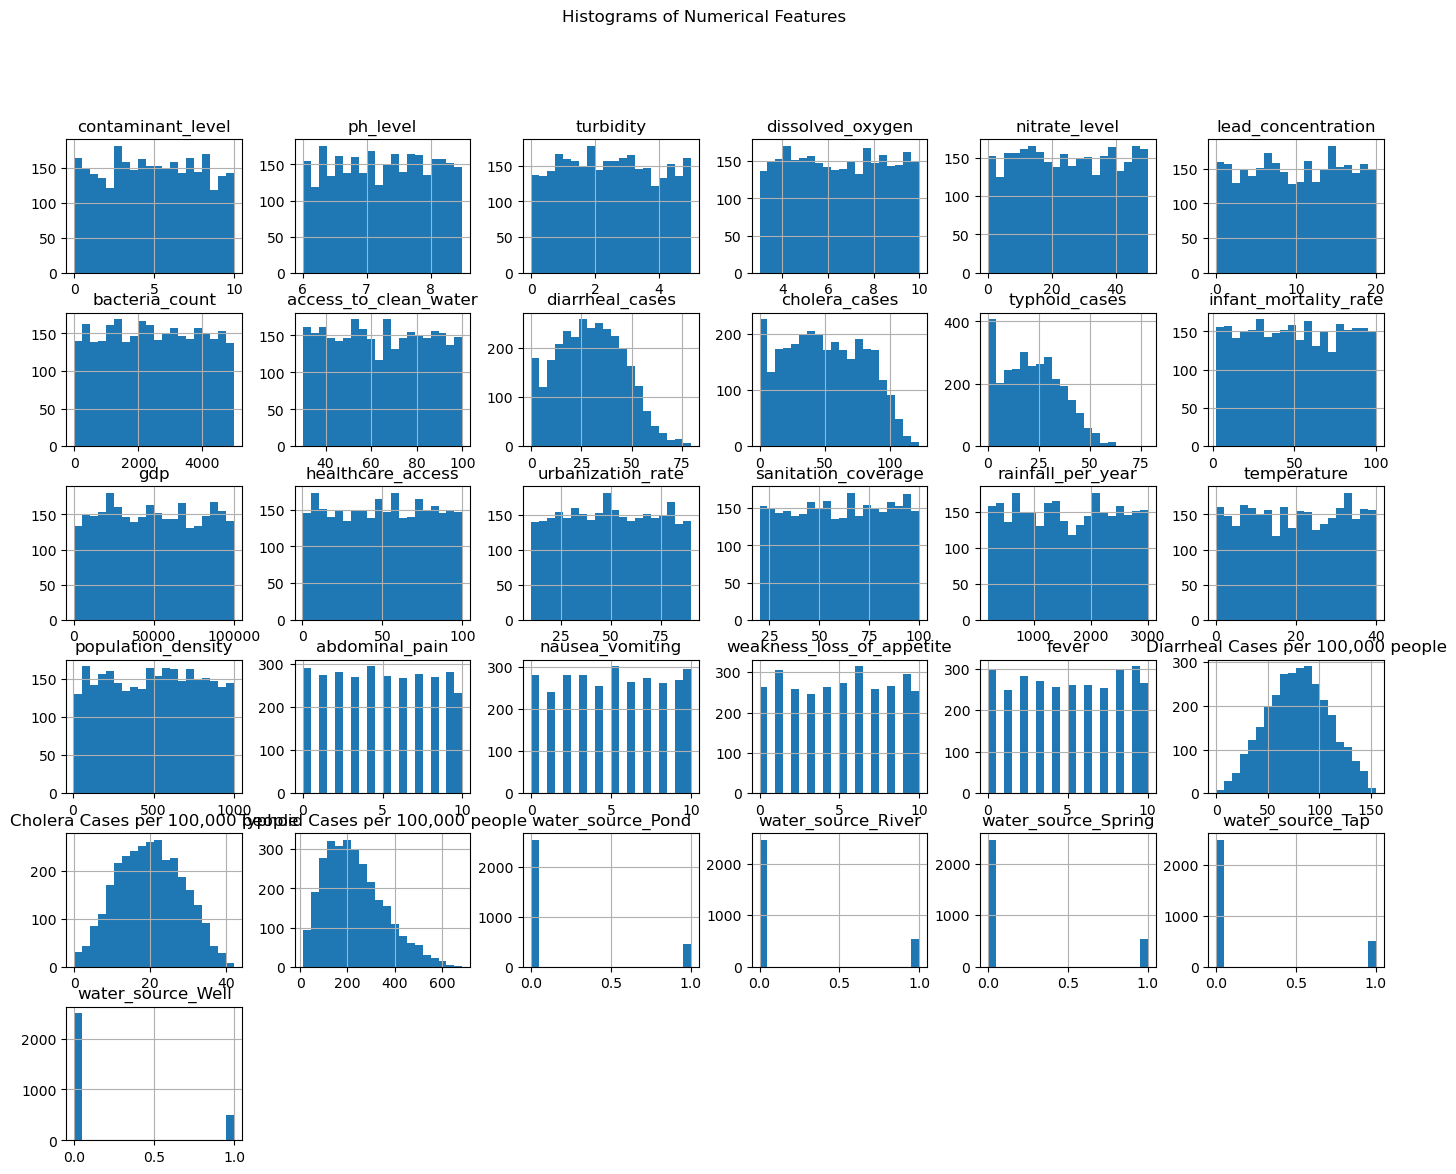

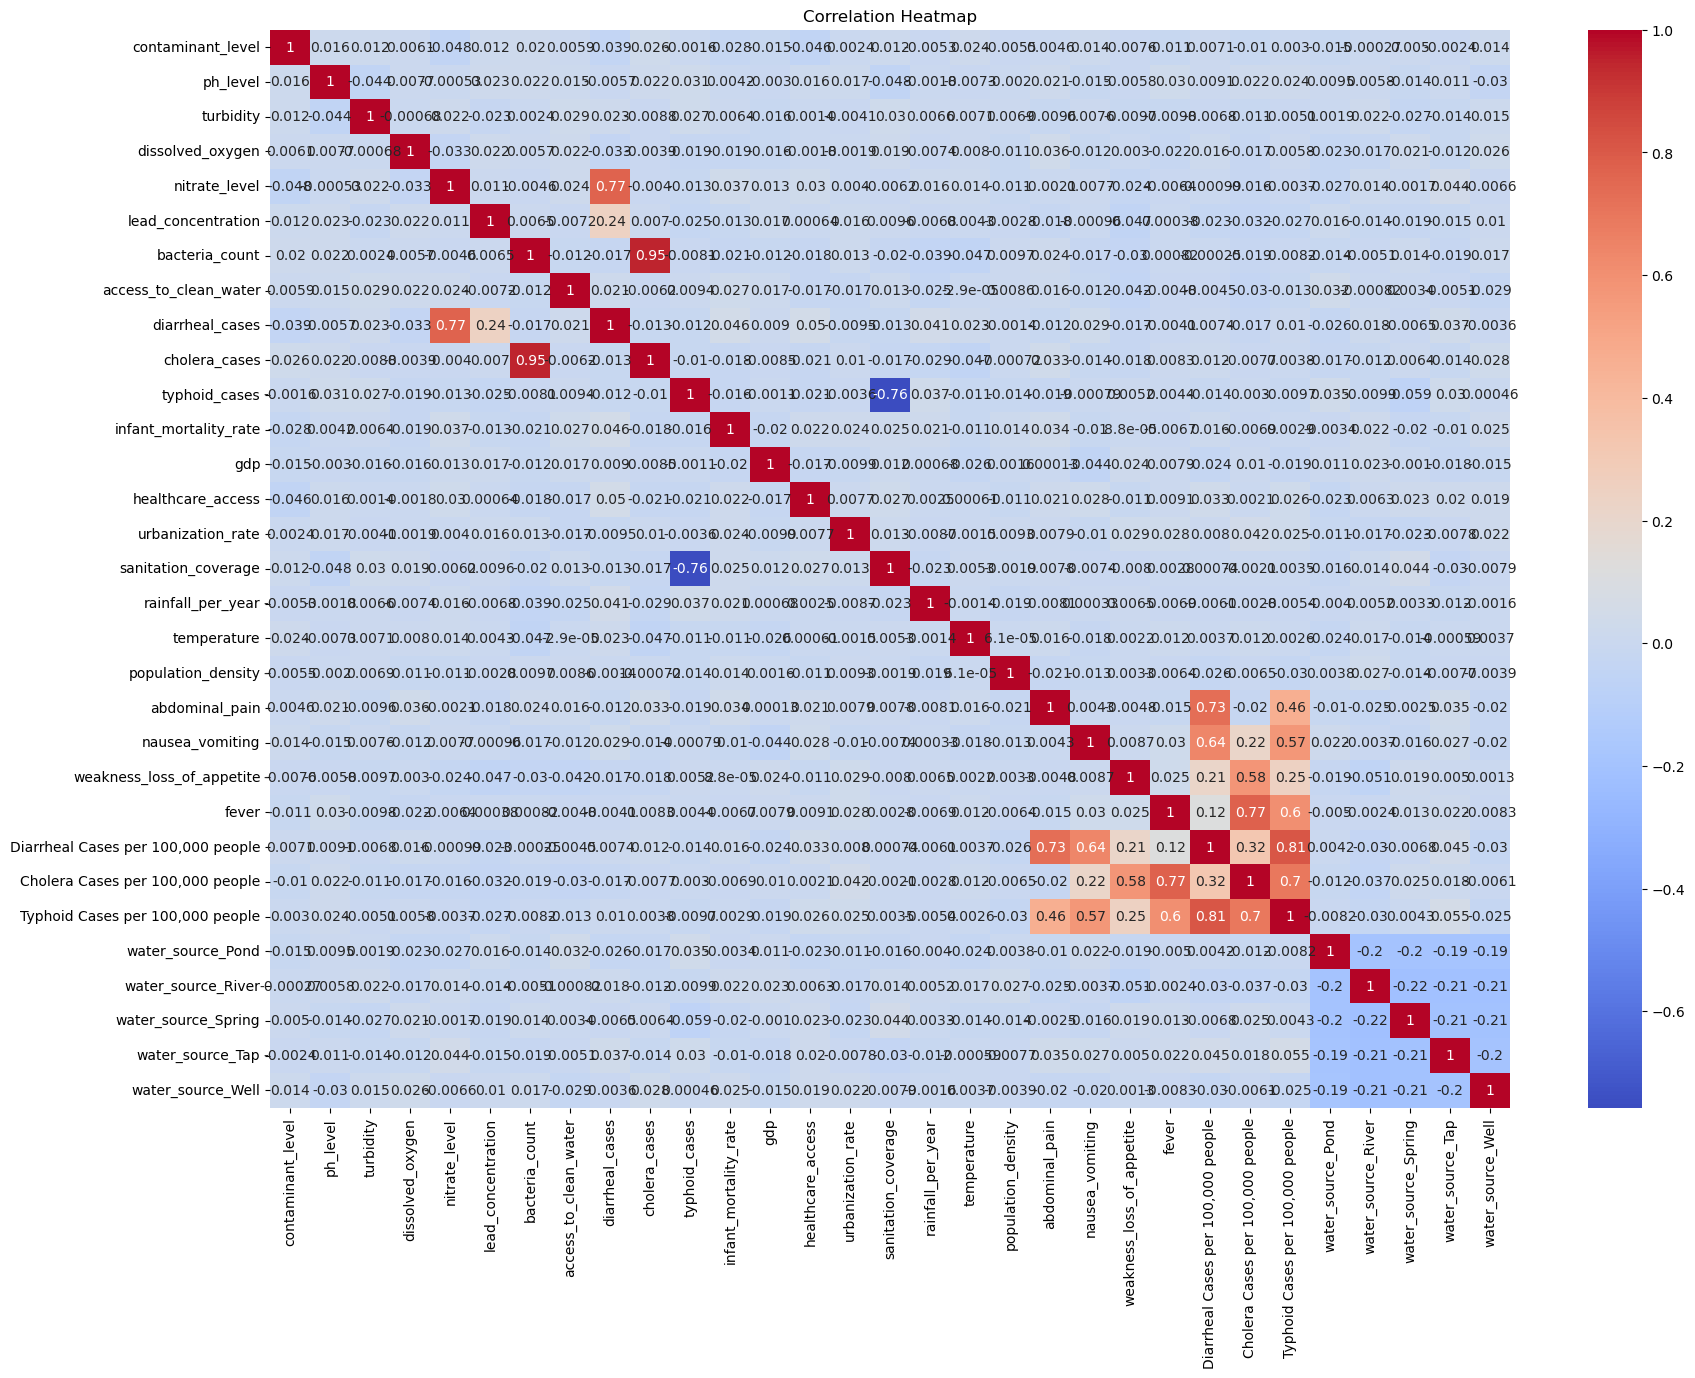

In [11]:

df.hist(figsize=(17, 13), bins=20)
plt.suptitle("Histograms of Numerical Features")
plt.show()


plt.figure(figsize=(20, 14))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [12]:
water_quality_features = ['contaminant_level','ph_level','turbidity','dissolved_oxygen','nitrate_level', 'lead_concentration', 'bacteria_count', 'diarrheal_cases', 'cholera_cases','typhoid_cases',]
df_water_quality = df[water_quality_features]

socio_features = ['access_to_clean_water','infant_mortality_rate','gdp','healthcare_access', 'urbanization_rate', 'sanitation_coverage','rainfall_per_year', 'temperature','diarrheal_cases','population_density', 'cholera_cases','typhoid_cases',]
df_socio = df[socio_features]

In [13]:
water_quality_features_pred = [
    'contaminant_level','ph_level','turbidity','dissolved_oxygen',
    'nitrate_level','lead_concentration','bacteria_count'
]

socio_features_pred = [
    'water_source_Pond','water_source_River','water_source_Spring',
    'water_source_Tap','water_source_Well',
    'access_to_clean_water','infant_mortality_rate','gdp',
    'healthcare_access','urbanization_rate','sanitation_coverage',
    'rainfall_per_year','temperature','population_density'
]

symptom_features_pred = [
    'abdominal_pain', 'nausea_vomiting', 'weakness_loss_of_appetite', 'fever'
]

water_quality_features_pred += symptom_features_pred
socio_features_pred += symptom_features_pred

In [15]:

trained_models = {}


X = df[water_quality_features_pred]
y = df['diarrheal_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
trained_models['diarrheal'] = rf
print("Diarrheal model trained (water + symptom features).")

X = df[water_quality_features_pred]
y = df['cholera_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
trained_models['cholera'] = rf
print("Cholera model trained (water + symptom features).")

X = df[socio_features_pred]
y = df['typhoid_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
trained_models['typhoid'] = rf
print("Typhoid model trained (socio + symptom features).")


Diarrheal model trained (water + symptom features).
Cholera model trained (water + symptom features).
Typhoid model trained (socio + symptom features).


In [16]:
for disease, model in trained_models.items():
    if disease in ['diarrheal', 'cholera']:
        X_test = df[water_quality_features_pred]  
        y_test = df[f'{disease}_cases']
    else:  # typhoid
        X_test = df[socio_features_pred]
        y_test = df['typhoid_cases']

    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"--- {disease.capitalize()} ---")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Predictions (first 5): {y_pred[:5]}\n")


--- Diarrheal ---
R² Score: 0.8780
RMSE: 5.7477
Predictions (first 5): [13.51120791 32.15408973 33.41974021 31.40644893 48.09259485]

--- Cholera ---
R² Score: 0.9674
RMSE: 5.4221
Predictions (first 5): [66.7583686  36.80262661 67.01317398 92.89267802 85.65030726]

--- Typhoid ---
R² Score: 0.8592
RMSE: 5.3960
Predictions (first 5): [25.42034359 32.49626719  6.81665112  1.71926189 17.53808887]



In [17]:
# -------------------------
#testing with manual data
# -------------------------
new_water_quality_data = pd.DataFrame([
    {
        # Worst case: highly polluted river, unsafe water
        'contaminant_level': 12.0,
        'ph_level': 5.5,
        'turbidity': 35.0,
        'dissolved_oxygen': 1.5,
        'nitrate_level': 40.0,
        'lead_concentration': 20.0,
        'bacteria_count': 2000
    },
    {
        # Very poor water quality: rural pond
        'contaminant_level': 8.5,
        'ph_level': 6.0,
        'turbidity': 25.0,
        'dissolved_oxygen': 3.0,
        'nitrate_level': 25.0,
        'lead_concentration': 12.0,
        'bacteria_count': 1200
    },
    {
        # Moderate water quality: community well
        'contaminant_level': 4.0,
        'ph_level': 7.0,
        'turbidity': 12.0,
        'dissolved_oxygen': 5.5,
        'nitrate_level': 12.0,
        'lead_concentration': 5.0,
        'bacteria_count': 400
    },
    {
        # Good water quality: spring water
        'contaminant_level': 1.2,
        'ph_level': 7.5,
        'turbidity': 5.0,
        'dissolved_oxygen': 7.5,
        'nitrate_level': 3.5,
        'lead_concentration': 1.5,
        'bacteria_count': 120
    },
    {
        # Best case: treated tap water
        'contaminant_level': 0.3,
        'ph_level': 7.2,
        'turbidity': 1.0,
        'dissolved_oxygen': 9.0,
        'nitrate_level': 0.8,
        'lead_concentration': 0.2,
        'bacteria_count': 10
    }
])

new_socio_data = pd.DataFrame([
    {
        # Worst case: rural, no sanitation, low GDP
        'water_source_Pond': 0,
        'water_source_River': 1,
        'water_source_Spring': 0,
        'water_source_Tap': 0,
        'water_source_Well': 0,
        'access_to_clean_water': 30.0,
        'infant_mortality_rate': 45.0,
        'gdp': 1500.0,
        'healthcare_access': 20.0,
        'urbanization_rate': 10.0,
        'sanitation_coverage': 15.0,
        'rainfall_per_year': 1800.0,
        'temperature': 33.0,
        'population_density': 800
    },
    {
        # Poor case: rural pond/river water
        'water_source_Pond': 1,
        'water_source_River': 0,
        'water_source_Spring': 0,
        'water_source_Tap': 0,
        'water_source_Well': 0,
        'access_to_clean_water': 50.0,
        'infant_mortality_rate': 30.0,
        'gdp': 4000.0,
        'healthcare_access': 40.0,
        'urbanization_rate': 25.0,
        'sanitation_coverage': 35.0,
        'rainfall_per_year': 1500.0,
        'temperature': 30.0,
        'population_density': 500
    },
    {
        # Moderate case: semi-urban, community wells
        'water_source_Pond': 0,
        'water_source_River': 0,
        'water_source_Spring': 0,
        'water_source_Tap': 0,
        'water_source_Well': 1,
        'access_to_clean_water': 70.0,
        'infant_mortality_rate': 18.0,
        'gdp': 9000.0,
        'healthcare_access': 60.0,
        'urbanization_rate': 45.0,
        'sanitation_coverage': 60.0,
        'rainfall_per_year': 1300.0,
        'temperature': 27.0,
        'population_density': 300
    },
    {
        # Good case: spring + partial tap
        'water_source_Pond': 0,
        'water_source_River': 0,
        'water_source_Spring': 1,
        'water_source_Tap': 0,
        'water_source_Well': 0,
        'access_to_clean_water': 90.0,
        'infant_mortality_rate': 8.0,
        'gdp': 20000.0,
        'healthcare_access': 80.0,
        'urbanization_rate': 60.0,
        'sanitation_coverage': 85.0,
        'rainfall_per_year': 1200.0,
        'temperature': 26.0,
        'population_density': 200
    },
    {
        # Best case: urban, modern infrastructure
        'water_source_Pond': 0,
        'water_source_River': 0,
        'water_source_Spring': 0,
        'water_source_Tap': 1,
        'water_source_Well': 0,
        'access_to_clean_water': 99.0,
        'infant_mortality_rate': 2.0,
        'gdp': 35000.0,
        'healthcare_access': 98.0,
        'urbanization_rate': 80.0,
        'sanitation_coverage': 99.0,
        'rainfall_per_year': 1100.0,
        'temperature': 24.0,
        'population_density': 150
    }
])

new_symptom_data = pd.DataFrame([
    {
        # Worst case: very sick population
        'abdominal_pain': 1,
        'nausea_vomiting': 4,
        'weakness_loss_of_appetite':5,
        'fever': 1
    },
    {
        # Poor case: some symptoms
        'abdominal_pain': 1,
        'nausea_vomiting': 4,
        'weakness_loss_of_appetite': 2,
        'fever': 0
    },
    {
        # Moderate case: few symptoms
        'abdominal_pain': 0,
        'nausea_vomiting': 2,
        'weakness_loss_of_appetite': 0,
        'fever': 1
    },
    {
        # Good case: mostly healthy
        'abdominal_pain': 0,
        'nausea_vomiting': 1,
        'weakness_loss_of_appetite': 0,
        'fever': 0
    },
    {
        # Best case: healthy population
        'abdominal_pain': 0,
        'nausea_vomiting': 0,
        'weakness_loss_of_appetite': 0,
        'fever': 0
    }
])

In [18]:
combined_data = pd.concat(
    [new_water_quality_data.reset_index(drop=True),
     new_socio_data.reset_index(drop=True),
     new_symptom_data.reset_index(drop=True)],  # add this
    axis=1
)

# prediction 
combined_data['pred_diarrheal'] = trained_models['diarrheal'].predict(
    combined_data[water_quality_features_pred]
)

combined_data['pred_cholera'] = trained_models['cholera'].predict(
    combined_data[water_quality_features_pred]
)

combined_data['pred_typhoid'] = trained_models['typhoid'].predict(
    combined_data[socio_features_pred]  
)

print(combined_data[['pred_diarrheal','pred_cholera','pred_typhoid']])




   pred_diarrheal  pred_cholera  pred_typhoid
0       49.428297     41.720118     45.112784
1       30.103331     27.173100     31.613174
2       12.546582      8.728441     22.632848
3       11.675377     12.676097     10.249291
4       10.112741      7.362882      9.664756


In [19]:
joblib.dump(trained_models['diarrheal'], "diarrheal_model.pkl")
joblib.dump(trained_models['cholera'], "cholera_model.pkl")
joblib.dump(trained_models['typhoid'], "typhoid_model.pkl")

['typhoid_model.pkl']

In [21]:
df.to_csv("water_pollution_with_symptoms_dataset.csv", index=False)